In [1]:
import pandas as pd
import numpy as np
import sshtunnel
import paramiko
import pymysql
#import sqlalchemy
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)
import random 
import string 

# Data Integration 

## Read all fake data

In [2]:
def read_csv(file_name):
    dataframe = pd.read_csv(f'{file_name}.csv', index_col = 0)
    return dataframe


In [3]:
path = '/Users/sunsun/Desktop/RMDS/wk8/code/fake_dataframes/'
cert = read_csv(f'{path}/f_cert')
competition = read_csv(f'{path}/f_competition')
evbr = read_csv(f'{path}/f_evbr')
github = read_csv(f'{path}/f_github')
imp_detail = read_csv(f'{path}/f_imp_detail') 
scoring_colums = read_csv(f'{path}/f_scoring_colums')
sql_employee = read_csv(f'{path}/f_sql_employee')
sql_expert_list02 = read_csv(f'{path}/f_sql_expert_list02')
sql_project_impactor_list02 = read_csv(f'{path}/f_sql_project_impactor_list02')
summary_bool = read_csv(f'{path}/f_summary_bool')
users = read_csv(f'{path}/f_users')
weights = read_csv(f'{path}/f_weights')

## competition

In [4]:
competition

,webform_id,sid,name,property,delta,value
0,2021_competition,1023,email_primary,NaN,0,cber@test.com
1,2021_competition,1023,members,member_email,0,fgqo@test.com
2,2021_competition,1023,members,member_name,0,Suha
3,2021_competition,1023,mentor_email,NaN,0,NaN
4,2021_competition,1023,mentor_name,NaN,0,NaN
...,...,...,...,...,...,...
5195,2021_competition,2630,mentor_email,NaN,0,NaN
5196,2021_competition,2630,mentor_name,NaN,0,NaN
5197,2021_competition,2630,phone_number,NaN,0,NaN
5198,2021_competition,2630,referral_source,NaN,0,Your university


In [5]:
competition['name'].value_counts()

members                    1594
referral_source             442
what_is_your_team_name_     442
mentor_name                 442
email_primary               442
mentor_email                442
checkbox                    441
indonesian_contestant       327
phone_number                321
ig_username                 307
Name: name, dtype: int64

In [6]:
def competition_made(df):
    competition_grouped  = df.groupby('sid')
    features_multi_rows = ['members']
    list_competitors = []
    
    for name, group in competition_grouped:
        dic_to_append = {'sid': name}
        for i, row in group.iterrows():
            if (row['name'] != 'checkbox') and (row['name'] != 'members'):
                dic_to_append[row['name']] = row['value']
            elif (row['name'] != 'checkbox') and (row['name'] == 'members'):
                if row['property'] not in dic_to_append:
                    dic_to_append[row['property']] = []
                dic_to_append[row['property']].append(row['value'])
        list_competitors.append(dic_to_append)

    df = pd.DataFrame(list_competitors)
    df['member_email'] = df['member_email'].map(lambda x: [] if x is np.nan else x)
    
    return df 

    

In [7]:
competition = competition_made(competition)
#competition

In [8]:
def competition_remove_test(df, removed):
    df = df[~df['email_primary'].str.contains(removed)]
    return df


In [9]:
removes = ['test', 'rmds', 'aliciaewei@gmail.com']
for remove in removes:
    competition = competition_remove_test(competition, remove)
    
#competition

In [10]:
def list_competitors(df):
    list_competitors = []
    for i, row in df.iterrows():
        dic_to_append = {'email': row['email_primary']}
        dic_to_append['name'] = ''
        dic_to_append['type'] = '3 team lead'
        list_competitors.append(dic_to_append)
    
        dic_to_append = {'email': row['mentor_email']}
        dic_to_append['name'] = row['mentor_name']
        dic_to_append['type'] = '1 mentor'
        list_competitors.append(dic_to_append)
    
        for j in range(len(row['member_email'])):
            dic_to_append = {'email': row['member_email'][j]}
            dic_to_append['name'] = row['member_name'][j]
            dic_to_append['type'] = '2 team member'
            list_competitors.append(dic_to_append)
            
    df = pd.DataFrame(list_competitors)
    return df 



In [11]:
competitors = list_competitors(competition)
competitors

,email,name,type
0,tsls@gmail.com,,3 team lead
1,NaN,NaN,1 mentor
2,uuqi@gmail.com,Shivam Pandey,2 team member
3,dgib@gmail.com,Surabhi Pandey,2 team member
4,zqbn@gmail.com,,3 team lead
...,...,...,...
1666,NaN,Yong wu,2 team member
1667,mlvy@gmail.com,,3 team lead
1668,NaN,NaN,1 mentor
1669,yzkq@gmail.com,Soumil Mukherjee,2 team member


In [12]:
def competitor_organized(df):
    df = df.groupby('email').max().reset_index()
    df = df.dropna(subset=['email'])
    df = df[df['email'] != '']
    return df 


In [13]:
competitors = competitor_organized(competitors)

In [14]:
competitors

,email,name,type
0,Aayushya Gupta,Rohan Gupta,2 team member
1,Achmad Luthfi Putra Yogi,Febrianti Silviana Saputri,2 team member
2,Achmad Youngky Fernando,Shandy Maulana Yudantiar,2 team member
3,Ahmad Ulfi Jihad Dzulqornain,Agustina Nurindra Saputri,2 team member
4,Akhil Pramod Emani,Sahil Gandhi,2 team member
...,...,...,...
1203,zvku@ad.unc.edu,YUE FENG,2 team member
1204,zvtq@ucf.edu,Christian Keller,2 team member
1205,zwoy@gmail.com,,3 team lead
1206,zxzu@gmail.com,,3 team lead


## User table

In [15]:
users['competition_2021q1'] = users.email.isin(list(competitors.email))
users['competition_y_n'] = users['competition_2021q1'] + users['competition_2020']
users.head()

,uid,email,competition_2020,competition_winner_place,shop_txn,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses_completed,competition_2021q1,competition_y_n
0,2228,ciao@qq.com,1,0,0,1,2020-05-20,646.0,2020-05-20,646.0,0,False,1
1,2155,yjmy@zju.edu.cn,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1
2,2482,gwec@qq.com,1,0,1,1,2020-05-31,635.0,2020-06-01,634.0,0,False,1
3,2568,vhlp@qq.com,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1
4,2206,wrwb@gmail.com,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1


In [16]:
def add_2021_competition(df1, df2, df3):
    df1['competition_2021q1'] = df1.email.isin(list(df2.email))
    df1['competition_y_n'] = df1['competition_2021q1'] + df1['competition_2020']
    
    first_list = df3[df3['what_is_your_team_name_']=='Insight Finders']['member_email'].values.tolist()[0]
    second_list = df3[df3['what_is_your_team_name_']=='5ACES']['member_email'].values.tolist()[0]
    third_list = df3[df3['what_is_your_team_name_']=='Data Garage']['member_email'].values.tolist()[0]
    
    
    for email in first_list:
        df1.loc[df1[df1['email'] == email.strip()].index,'competition_winner_place'] = 1
    for email in second_list:
        df1.loc[df1[df1['email'] == email.strip()].index,'competition_winner_place'] = 2
    for email in third_list:
        df1.loc[df1[df1['email'] == email.strip()].index,'competition_winner_place'] = 3
        
    return df1



In [17]:
users = add_2021_competition(users, competitors, competition)
users

,uid,email,competition_2020,competition_winner_place,shop_txn,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses_completed,competition_2021q1,competition_y_n
0,2228,ciao@qq.com,1,0,0,1,2020-05-20,646.0,2020-05-20,646.0,0,False,1
1,2155,yjmy@zju.edu.cn,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1
2,2482,gwec@qq.com,1,0,1,1,2020-05-31,635.0,2020-06-01,634.0,0,False,1
3,2568,vhlp@qq.com,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1
4,2206,wrwb@gmail.com,1,0,0,0,NaN,NaN,NaN,NaN,0,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5543,17372,gzpg@gmail.com,0,0,0,0,NaN,NaN,NaN,NaN,0,False,0
5544,17373,zvvc@gmail.com,0,0,0,1,2022-02-23,2.0,2022-02-23,2.0,0,False,0
5545,17374,ndvi@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,False,0
5546,17375,lyum@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,False,0


## Eventbrite

In [18]:
#Get event data
def get_evbr_emails(df_evbr):
    df_evbr2 = pd.DataFrame()
    dic_to_append = {}
    for email in df_evbr['email'].unique():
        dic_to_append['mail'] = email
        df_evbr2 = df_evbr2.append(dic_to_append, ignore_index=True)
        dic_to_append = {}
    df_evbr = df_evbr2
    return df_evbr

    
evbr = get_evbr_emails(evbr)
evbr

,mail
0,nxra@Virtualitics.com
1,waby@legacy.film
2,itac@innovatepasadena.org
3,ifsn@gmail.com
4,ygdw@fjuhsd.org
...,...
2250,tqnc@qq.com
2251,qkmx@gmail.com
2252,zjgi@gmail.com
2253,bwqx@qq.com


In [19]:
def merge_data(df_grmds, df_evbr):
    df = df_grmds.merge(df_evbr, left_on='email', right_on='mail', how='left')
    df['im_data_y_n'] = df['mail']
    for index, row in df.iterrows():
        if pd.isnull(df['mail'][index]) == True:
            df['im_data_y_n'][index] = 0
        else:
            df['im_data_y_n'][index] = 1
    return df

df = merge_data(users, evbr)
df_final = df[['uid', 'email', 'competition_y_n', 'competition_winner_place',
       'shop_txn', 'moodle_user_y_n', 'moodle_first_login_dt',
       'moodle_first_login_days_since', 'moodle_recent_login_dt',
       'moodle_recent_login_days_since', 'num_courses_completed',
       'im_data_y_n']]
#f_final

<ipython-input-19-501f8eaf48e3>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['im_data_y_n'][index] = 0
<ipython-input-19-501f8eaf48e3>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['im_data_y_n'][index] = 1


In [20]:
cert

,uid,first_name,last_name,email,issue_date,type_program,type_issue,program_title,notes
0,8959.0,Topher,Allen,gthw@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
1,917.0,Nicole,Bibb,ugcg@blueshieldca.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
2,NaN,Isha,Brown,NaN,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
3,904.0,Kathryn,Brown,rfus@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
4,859.0,Kubilay,Dagtoros,jpwy@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
...,...,...,...,...,...,...,...,...,...
505,9220.0,Riyanna,Shabrina,ffcv@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,2021 Q2 second place
506,9464.0,Yogi,Anggara,urzy@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,2021 Q2 second place
507,9599.0,Gucheng,Jiang,wcnc@qq.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,2021 Q2 first place
508,1768.0,Yuxi,Ma,rekz@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,2021 Q2 first place


In [21]:
cert.groupby('email').filter(lambda x: len(x) > 1)

,uid,first_name,last_name,email,issue_date,type_program,type_issue,program_title,notes
7,985.0,Albert,Fattal,mfas@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
8,892.0,Enri'que,Flores,udla@hotmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
17,915.0,Dhamodharan,Kaliyaperumal,jdrk@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
22,901.0,Sean,Li,emcp@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
31,1326.0,Ryan,Swan,rcea@gmail.com,2019-12-05,Workshop,jointly issued with UCR,Accelerate\nyour Career with Big Data and AI,NaN
...,...,...,...,...,...,...,...,...,...
470,1768.0,Yuxi,Ma,rekz@gmail.com,2021-04-22,NaN,soley issued by GRMDS,Certified Junior Data Scientist,level2
487,6529.0,Mohammad,Qurtubi,qyci@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,
496,9334.0,Zhenchen,Hong,pkhc@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,
508,1768.0,Yuxi,Ma,rekz@gmail.com,2021-06-30,Competition,soley issued by GRMDS,2021 Post-COVID California Property Price Pred...,2021 Q2 first place


In [22]:
cert = cert[['email', 'uid']].groupby('email').count()
cert = cert.reset_index()
cert = cert.rename(columns={'uid':'num_certificate'})
cert

,email,num_certificate
0,acoz@usc.edu,1
1,aflc@gmail.com,1
2,aggg@douglas.co.us,1
3,agii@gmail.com,1
4,aiuc@gmail.com,6
...,...,...
243,zmsc@okstate.edu,1
244,zsjg@gmail.com,1
245,zsws@longevity-global.com,1
246,zusw@gmail.com,1


In [23]:
#merge certification data

df_final = df_final.merge(cert, left_on='email', right_on='email', how='left')

counter = 1
for i, row in df_final.iterrows():
    if pd.isnull(row['num_certificate']):
        df.loc[i, 'num_certificate'] = 0
    else:
        counter += 1
#print(counter)

df_final['num_certificate'].fillna(0,inplace=True)
df_final['num_certificate'] = df_final['num_certificate'].astype(int)
df_final 

,uid,email,competition_y_n,competition_winner_place,shop_txn,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses_completed,im_data_y_n,num_certificate
0,2228,ciao@qq.com,1,0,0,1,2020-05-20,646.0,2020-05-20,646.0,0,0,0
1,2155,yjmy@zju.edu.cn,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
2,2482,gwec@qq.com,1,0,1,1,2020-05-31,635.0,2020-06-01,634.0,0,0,0
3,2568,vhlp@qq.com,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
4,2206,wrwb@gmail.com,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5543,17372,gzpg@gmail.com,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0
5544,17373,zvvc@gmail.com,0,0,0,1,2022-02-23,2.0,2022-02-23,2.0,0,0,0
5545,17374,ndvi@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0
5546,17375,lyum@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0


In [24]:
df_output = df_final[['uid', 'email', 'competition_y_n', 'competition_winner_place',
       'shop_txn', 'moodle_user_y_n', 'moodle_first_login_dt',
       'moodle_first_login_days_since', 'moodle_recent_login_dt',
       'moodle_recent_login_days_since', 'num_courses_completed',
       'im_data_y_n', 'num_certificate']]

user_data_request = df_output.rename(columns = {"shop_txn": "shop_num_txn"})

## expert /PI /employees

In [25]:
#sql_expert_list02

In [26]:
sql_expert_list02 = sql_expert_list02.drop_duplicates(subset=['email'],keep='last')

# drop the rows that "uid" is missing
sql_expert_list02 = sql_expert_list02.dropna(subset=['uid'])

sql_expert_list02

,uid,first_name,last_name,email,role1,role2,role3
4,7565.0,Shawn,Gilbert,huib@rpi.edu,2020 Competition mentor,NaN,NaN
5,2314.0,Sharon,Hernandez,jcsc@gmail.com,2020 Competition mentor,NaN,NaN
9,2458.0,Cheryl,Carpenter,ikcu@umich.edu,2020 Competition mentor,NaN,NaN
10,2055.0,Michelle,Holder,prbr@eecs.umich.edu,2020 Competition mentor,NaN,NaN
13,2409.0,Richard,Singleton,ceak@cpp.edu,2020 Competition mentor,NaN,NaN
...,...,...,...,...,...,...,...
161,6252.0,Joseph,Bender,anrd@yahoo.com,2021 Q1 Competition mentor,NaN,NaN
165,6311.0,Michelle,Martinez,qzdo@gmail.com,2021 Q1 Competition mentor,NaN,NaN
167,6364.0,Victor,Clark,ywtk@gmail.com,2021 Q1 Competition mentor,NaN,NaN
177,7879.0,Monica,Fernandez,ndwg@okstate.edu,2021 Q1 Competition mentor,NaN,NaN


In [27]:
# getting a data frame containing uid of PI from sql server
sql_project_impactor_list02 = sql_project_impactor_list02.drop_duplicates(subset=['email'],keep='last')

# drop the rows that "uid" is missing
sql_project_impactor_list02 = sql_project_impactor_list02.dropna(subset=['uid'])

sql_project_impactor_list02

,uid,name,email,college_university
0,2679.0,Michael Aguilar,mprm@gmail.com,University of Southern California
2,2767.0,Tony Hernandez,curk@drexel.edu,Drexel University
4,5173.0,Joshua Kim,hemp@columbia.edu,Columbia
6,4654.0,Amy White,bgum@northeastern.edu,Northeastern University
7,5498.0,Donald Lambert,gges@gmail.com,USC - BA
8,6922.0,Robert Yu,bnwk@northeastern.edu,Northeastern University -BA
9,6123.0,Kenneth Ballard,llqo@gmail.com,LMU-MSBA
10,9087.0,Mark Horne,pbgw@gmail.com,Worcester Polytechnic Institute
12,9199.0,Jesse Mcclure,svph@gmail.com,DePaul University
13,9161.0,Robert Ramos,umjn@illinois.edu,UIUC


In [28]:
# create a list of pi and experts 
sql_expert_list02_uid=[]
for i in sql_expert_list02['uid']:
    sql_expert_list02_uid.append(int(i))
    
sql_project_impactor_list02_uid=[]
for i in sql_project_impactor_list02['uid']:
    sql_project_impactor_list02_uid.append(int(i))

In [29]:
# project impacters_rmds
sql_project_impactor_list02['volunteer']= 1
impacter = sql_project_impactor_list02
impacter


,uid,name,email,college_university,volunteer
0,2679.0,Michael Aguilar,mprm@gmail.com,University of Southern California,1
2,2767.0,Tony Hernandez,curk@drexel.edu,Drexel University,1
4,5173.0,Joshua Kim,hemp@columbia.edu,Columbia,1
6,4654.0,Amy White,bgum@northeastern.edu,Northeastern University,1
7,5498.0,Donald Lambert,gges@gmail.com,USC - BA,1
8,6922.0,Robert Yu,bnwk@northeastern.edu,Northeastern University -BA,1
9,6123.0,Kenneth Ballard,llqo@gmail.com,LMU-MSBA,1
10,9087.0,Mark Horne,pbgw@gmail.com,Worcester Polytechnic Institute,1
12,9199.0,Jesse Mcclure,svph@gmail.com,DePaul University,1
13,9161.0,Robert Ramos,umjn@illinois.edu,UIUC,1


In [30]:
summary = summary_bool

# user_data_request2_alicia
alicia = user_data_request
alicia=alicia.rename(columns={'competition_y_n':'num_of_competition','shop_num_txn':'num_shop',
                              'im_data_y_n':'imdata','num_courses_completed':'num_courses'})

alicia

,uid,email,num_of_competition,competition_winner_place,num_shop,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses,imdata,num_certificate
0,2228,ciao@qq.com,1,0,0,1,2020-05-20,646.0,2020-05-20,646.0,0,0,0
1,2155,yjmy@zju.edu.cn,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
2,2482,gwec@qq.com,1,0,1,1,2020-05-31,635.0,2020-06-01,634.0,0,0,0
3,2568,vhlp@qq.com,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
4,2206,wrwb@gmail.com,1,0,0,0,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5543,17372,gzpg@gmail.com,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0
5544,17373,zvvc@gmail.com,0,0,0,1,2022-02-23,2.0,2022-02-23,2.0,0,0,0
5545,17374,ndvi@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0
5546,17375,lyum@columbia.edu,0,0,0,0,NaN,NaN,NaN,NaN,0,0,0


In [31]:
# user_github
github = github[['uid','follower_number', 'languages', 'repo_number',
       'repo_name', 'star_number']]
github

,uid,follower_number,languages,repo_number,repo_name,star_number
0,110,0,"['JupyterNotebook', 'JupyterNotebook', 'Jupyte...",14,"['Hurricane', 'BSAN6070-CA-Chen', 'nlp-in-pyth...",32
1,333,0,"['JupyterNotebook', 'JupyterNotebook', 'Jupyte...",14,"['Hurricane', 'BSAN6070-CA-Chen', 'nlp-in-pyth...",32
2,488,0,"['JupyterNotebook', 'JupyterNotebook', 'Jupyte...",14,"['Hurricane', 'BSAN6070-CA-Chen', 'nlp-in-pyth...",32
3,679,0,"['JupyterNotebook', 'JupyterNotebook', 'Jupyte...",14,"['Hurricane', 'BSAN6070-CA-Chen', 'nlp-in-pyth...",32
4,685,0,"['', 'Python', 'Python']",12,"['hello-world', 'cupy', 'home-assistant']",33
5,690,0,"['', 'Python', 'Python']",12,"['hello-world', 'cupy', 'home-assistant']",33
6,692,1 follower,"['Vue', '', 'JavaScript', 'JavaScript']",13,"['rsgis-gallery', 'Geodetic_Program', 'FileMan...",34
7,693,1 follower,"['Vue', '', 'JavaScript', 'JavaScript']",13,"['rsgis-gallery', 'Geodetic_Program', 'FileMan...",34
8,695,1 follower,"['Vue', '', 'JavaScript', 'JavaScript']",13,"['rsgis-gallery', 'Geodetic_Program', 'FileMan...",34
9,1025,0,"['', '', '', 'R', 'HTML']",14,"['HelloWord.md', 'datasharing', 'datascienceco...",32


In [32]:
# merge all things together
merge = pd.merge(imp_detail, impacter, on='uid', how='left')
merge = pd.merge(merge, summary, on='uid', how='left')
merge = pd.merge(merge, alicia, on='uid', how='left')
isc= pd.merge(merge, github, on='uid', how='left')
isc

,uid,time,score_five_stars,num_five_stars,score_four_stars,num_four_stars,score_highest_rating,num_highest_rating,score_average_rating,num_average_rating,score_total_entity_involved,num_total_entity_involved,score_comment_count,num_comment_count,score_project_complete_num,num_project_complete_num,score_upload_count,num_upload_count,score_repos,num_repos,score_total_ppl_impacted,num_total_ppl_impacted,score_total_revenue,num_total_revenue,score_social_num,social_num,score_sum_num_visitors,sum_num_visitors,score_part_num_visitors,part_num_visitors,score_likes_value,num_likes_value,score_followers,num_followers,score_followers_sub,num_followers_sub,score_forum_count,num_forum_count,score_num_skills,num_skills,score_count_rating,count_rating,score_sum_num_views,sum_num_views,score_num_rate_give,num_rate_give,score_num_comment_give,num_comment_give,score_following,num_following,score_competition,num_competition,score_num_click,num_click,score_university,university,score_company,company,score_num_interests,num_interests,project_files_size_total,types_of_files_total,numberof_recent_uploads,num_recent_active_days_L180D,num_recent_viewing_others_L180D,num_days_last_login,num_days_last_upload,name,email_x,college_university,volunteer,summary_bool,email_y,num_of_competition,competition_winner_place,num_shop,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses,imdata,num_certificate,follower_number,languages,repo_number,repo_name,star_number
0,7937,2021-08-17 23:07:42,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,NaN,100.0,google,0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10697,2022-02-25 06:00:42,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,2.63889,1,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',100.0,'Lampung University ',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,wvnt@gmail.com,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
2,5511,2022-02-25 06:00:21,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,NaN,NaN,0.000000,0,NaN,NaN,0.00000,0,NaN,NaN,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',0.0,'',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,jffi@yahoo.com,0.0,0.0,0.0,1.0,2021-01-27,394.0,2021-02-08,382.0,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN
3,669,2021-08-17 14:19:16,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,5.29006,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,NaN,0.0,NaN,0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2260,2022-02-25 06:00:14,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,NaN,NaN,0.000000,0,NaN,NaN,0.00000,0,NaN,NaN,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',0.0,'',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,qjzd@gmail.com,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,16260,2022-02-25 06:00:44,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',100.0,'Providence College',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,vqku

## User score
Calculting the user score based on the scoring columns and weight tables. 
- The scoring_columns table helps us give each corresponding category and metrics an appropriate method. In addition, it sets up an upper bound to prevent the user scores from varying too much. 
- The weight table helps us weigh each user’s behavior and profile data and provide a relatively fair score. 

In [33]:
# Importing scoring constants 
scoring_cols = scoring_colums
scoring_cols=scoring_cols.dropna(subset=['column_name'])

# convert "k" and "upper" columns from str to float 
scoring_cols['k']=scoring_cols['k'].astype('float')
scoring_cols['upper']=scoring_cols['upper'].astype('float')
scoring_cols

,column_name,calc_type,upper,k,raw
0,score_project_complete_num,log,1.500000e+01,3.528870e-01,num_project_complete_num
1,score_average_rating,linear_two_below,5.000000e+00,1.058661e+00,num_average_rating
2,score_five_stars,log,2.500000e+01,2.117322e-01,num_five_stars
3,project_files_size_total,linear,1.000000e+10,5.290000e-10,NaN
4,score_upload_count,linear,2.000000e+01,2.646652e-01,num_upload_count
5,numberof_recent_uploads,linear,2.000000e+01,2.646652e-01,NaN
6,score_comment_count,log,5.000000e+01,1.058661e-01,num_comment_count
7,score_total_entity_involved,NaN,1.000000e+01,5.293305e-01,num_total_entity_involved
8,score_sum_num_views,NaN,3.000000e+03,1.764435e-03,sum_num_views
9,score_total_ppl_impacted,validation,1.000000e+05,5.290000e-05,num_total_ppl_impacted


In [34]:
isc['badge']=0

for index, row in isc.iterrows():
    for uid in sql_expert_list02_uid:
        if uid == row['uid']:
            isc.loc[index, 'badge'] = 1


for index, row in isc.iterrows():
    for uid in sql_project_impactor_list02_uid:
        if uid == row['uid']:
            isc.loc[index, 'badge'] = 0.5

In [35]:
# Standardize all column names
isc.columns = [x.lower().replace(" ", "_").replace("-","_").replace(r"/","_").replace("\\","_") \
              .replace("$","").replace("%","").replace("#","number") for x in isc.columns]

isc

,uid,time,score_five_stars,num_five_stars,score_four_stars,num_four_stars,score_highest_rating,num_highest_rating,score_average_rating,num_average_rating,score_total_entity_involved,num_total_entity_involved,score_comment_count,num_comment_count,score_project_complete_num,num_project_complete_num,score_upload_count,num_upload_count,score_repos,num_repos,score_total_ppl_impacted,num_total_ppl_impacted,score_total_revenue,num_total_revenue,score_social_num,social_num,score_sum_num_visitors,sum_num_visitors,score_part_num_visitors,part_num_visitors,score_likes_value,num_likes_value,score_followers,num_followers,score_followers_sub,num_followers_sub,score_forum_count,num_forum_count,score_num_skills,num_skills,score_count_rating,count_rating,score_sum_num_views,sum_num_views,score_num_rate_give,num_rate_give,score_num_comment_give,num_comment_give,score_following,num_following,score_competition,num_competition,score_num_click,num_click,score_university,university,score_company,company,score_num_interests,num_interests,project_files_size_total,types_of_files_total,numberof_recent_uploads,num_recent_active_days_l180d,num_recent_viewing_others_l180d,num_days_last_login,num_days_last_upload,name,email_x,college_university,volunteer,summary_bool,email_y,num_of_competition,competition_winner_place,num_shop,moodle_user_y_n,moodle_first_login_dt,moodle_first_login_days_since,moodle_recent_login_dt,moodle_recent_login_days_since,num_courses,imdata,num_certificate,follower_number,languages,repo_number,repo_name,star_number,badge
0,7937,2021-08-17 23:07:42,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,NaN,100.0,google,0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,10697,2022-02-25 06:00:42,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,2.63889,1,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',100.0,'Lampung University ',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,wvnt@gmail.com,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
2,5511,2022-02-25 06:00:21,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,NaN,NaN,0.000000,0,NaN,NaN,0.00000,0,NaN,NaN,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',0.0,'',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,jffi@yahoo.com,0.0,0.0,0.0,1.0,2021-01-27,394.0,2021-02-08,382.0,1.0,1,1.0,NaN,NaN,NaN,NaN,NaN,0.0
3,669,2021-08-17 14:19:16,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,5.29006,1,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,NaN,0.0,NaN,0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,2260,2022-02-25 06:00:14,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,NaN,NaN,0.000000,0,NaN,NaN,0.00000,0,NaN,NaN,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',0.0,'',0.0,0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,qjzd@gmail.com,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0,0.0,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6703,16260,2022-02-25 06:00:44,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.000000,0,0.0,0.0,0.00000,0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0,0.00000,0,0.0,0,0.0,0,0.0,0,0.000000,0,0.0,'',100.0,'Providence College',0.0,0,0.0,0.0,0.0,0,

In [36]:
scoring_cols

,column_name,calc_type,upper,k,raw
0,score_project_complete_num,log,1.500000e+01,3.528870e-01,num_project_complete_num
1,score_average_rating,linear_two_below,5.000000e+00,1.058661e+00,num_average_rating
2,score_five_stars,log,2.500000e+01,2.117322e-01,num_five_stars
3,project_files_size_total,linear,1.000000e+10,5.290000e-10,NaN
4,score_upload_count,linear,2.000000e+01,2.646652e-01,num_upload_count
5,numberof_recent_uploads,linear,2.000000e+01,2.646652e-01,NaN
6,score_comment_count,log,5.000000e+01,1.058661e-01,num_comment_count
7,score_total_entity_involved,NaN,1.000000e+01,5.293305e-01,num_total_entity_involved
8,score_sum_num_views,NaN,3.000000e+03,1.764435e-03,sum_num_views
9,score_total_ppl_impacted,validation,1.000000e+05,5.290000e-05,num_total_ppl_impacted


In [37]:
def score_calc(scoring_cols):
    
    """ This function calculates each feature using scoring_cols """
    
    user_score=isc['uid']
    for index, row in scoring_cols.iterrows():
        score=pd.DataFrame()
        column=row['column_name']
        calc_type=row['calc_type']
        upper=row['upper']
        k=row['k']
        output='score_'+str(column)
        isc_col = isc[column]


        if column.startswith('score'):
            score=isc_col
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
            
            # Adding raw columns for already calculated columns 

#           column_num=column.replace('score_','num_')
            column_num=row['raw']
            #print(column)

            user_score = pd.concat([user_score,isc[column_num]],axis=1, sort=False)

            
        elif calc_type == 'log':
            z=-k*isc_col
            #print(z)
            z = z.astype(float)
            score[output] = 200/(1+np.exp(z))-100
            user_score = pd.concat([user_score, score], axis=1, sort=False)
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
        elif calc_type == ' 100-log':
            score[output] = 200/(1+np.exp(-k*isc_col))-100
            score[output] = 100-score[output]
            user_score = pd.concat([user_score, score], axis=1, sort=False)
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
        elif calc_type == 'linear':
            score[output] = isc_col.apply(lambda x: (100*x/upper) if (100*x/upper) < 100 else 100)
            user_score = pd.concat([user_score, score], axis=1, sort=False)
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
        elif calc_type == 'linear_two_below':
            score[output] = isc_col.apply(lambda x: round((100/3)*x-200/3,3) if (x>=2) else (0))
            user_score = pd.concat([user_score, score], axis=1, sort=False)
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
        elif calc_type == 'bolean':
            # change the bolean
            score[output] = isc_col.apply(lambda x: x*100)
            #print(score[output])
            user_score = pd.concat([user_score, score], axis=1, sort=False)
            user_score = pd.concat([user_score, isc_col], axis=1, sort=False)
    
    return user_score, score

In [38]:
user_score, score=score_calc(scoring_cols)

In [39]:
import csv

df_user=user_score

score_cols = [col for col in df_user.columns if 'score' in col]

score_cols = ['uid'] + score_cols
df_user = df_user[score_cols]

df_user = df_user.fillna(0)

# Initialize dictionary variables 
proj_quality_dict = dict()
proj_engagement_dict = dict()
proj_outcome_dict = dict()
perceived_capacity_dict = dict()
perceived_participation_dict = dict()
total_score_dict = dict()

dimension_to_metric_dict = dict()

dimension_weight_dict = dict()
metric_weight_dict = dict()

In [40]:
# use the wieght table from our database

for row in weights.values:
    dimension_weight_dict[row[1]] = float(row[2])
    metric_weight_dict[row[0]] = float(row[3])
    if row[1] in dimension_to_metric_dict:
        dimension_to_metric_dict[row[1]].append(row[0])
    else:
        dimension_to_metric_dict[row[1]] = []
        dimension_to_metric_dict[row[1]].append(row[0])

#print(dimension_to_metric_dict)
for dimension in dimension_to_metric_dict:
    df_user[dimension] = np.zeros(len(df_user))

for dimension in dimension_to_metric_dict:
    for metric in dimension_to_metric_dict[dimension]:
        if metric in user_score.columns:
            df_user[dimension] += df_user[metric] * metric_weight_dict[metric]
        
df_user["total_score"] = np.zeros(len(df_user))
for dimension in dimension_to_metric_dict:
    df_user["total_score"] += df_user[dimension] * dimension_weight_dict[dimension]

In [41]:
df_user = df_user.sort_values(by=["total_score"], ascending=False)
df_user['rank'] = df_user['total_score'].rank(method='min',ascending=False)
df_user = df_user[['uid','proj_quality','proj_engagement','proj_outcome','perceived_capacity','perceived_participation',
                   'total_score','rank']]
df_user.columns = ['uid','quality','engagement','outcome','capacity','participation','score','rank']

## EAD

In [42]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline


In [43]:
df_user

,uid,quality,engagement,outcome,capacity,participation,score,rank
4957,678,99.13124,20.00000,39.917340,18.248190,30.540844,40.569964,1.0
2755,488,55.46828,16.60725,73.274514,49.247930,25.744932,40.277775,2.0
2937,679,50.88815,4.84922,50.643214,30.022298,36.244335,33.190548,3.0
2333,2985,76.43688,9.99678,0.000000,34.802788,38.052800,30.988984,4.0
5772,246,65.10512,18.86841,1.058412,41.456600,28.443961,29.376955,5.0
...,...,...,...,...,...,...,...,...
1075,6904,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,5010.0
5432,2034,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,5010.0
2184,735,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,5010.0
5430,2683,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000,5010.0


In [44]:
df_user[['quality', 'engagement', 'outcome', 'capacity', 'participation', 'score']].corr()

,quality,engagement,outcome,capacity,participation,score
quality,1.000000,0.775637,0.149056,0.177118,0.359198,0.782972
engagement,0.775637,1.000000,0.249882,0.186506,0.440636,0.732727
outcome,0.149056,0.249882,1.000000,0.167154,0.195888,0.473232
capacity,0.177118,0.186506,0.167154,1.000000,0.177004,0.614030
participation,0.359198,0.440636,0.195888,0.177004,1.000000,0.609815
score,0.782972,0.732727,0.473232,0.614030,0.609815,1.000000


<Figure size 648x576 with 0 Axes>

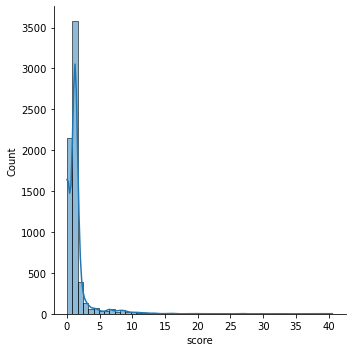

In [45]:
plt.figure(figsize = (9, 8))
sns.displot(df_user['score'],bins=50, kde=True)


## Analysis 

In [46]:
import sklearn 

In [47]:
scores = df_user.copy()
scores.head()

,uid,quality,engagement,outcome,capacity,participation,score,rank
4957,678,99.13124,20.00000,39.917340,18.248190,30.540844,40.569964,1.0
2755,488,55.46828,16.60725,73.274514,49.247930,25.744932,40.277775,2.0
2937,679,50.88815,4.84922,50.643214,30.022298,36.244335,33.190548,3.0
2333,2985,76.43688,9.99678,0.000000,34.802788,38.052800,30.988984,4.0
5772,246,65.10512,18.86841,1.058412,41.456600,28.443961,29.376955,5.0


In [49]:
# keep necessary columns 
scores = scores.drop(['rank', 'uid'] ,1)

In [50]:
# Standardize the data
cols = scores.columns 
from sklearn.preprocessing import MinMaxScaler
ms = MinMaxScaler()
scores = ms.fit_transform(scores)
scores = pd.DataFrame(scores, columns = [cols])
scores.head()

,quality,engagement,outcome,capacity,participation,score
0,1.000000,1.000000,0.544764,0.271637,0.802591,1.000000
1,0.559544,0.830363,1.000000,0.733089,0.676558,0.992798
2,0.513341,0.242461,0.691144,0.446903,0.952475,0.818106
3,0.771068,0.499839,0.000000,0.518063,1.000000,0.763841
4,0.656757,0.943421,0.014444,0.617110,0.747487,0.724106


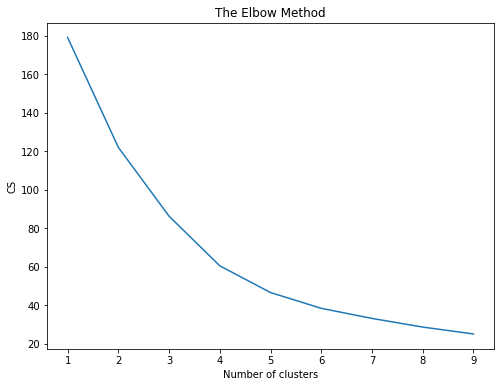

In [51]:
# Employ KMeans
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt
cs = []
for i in range(1, 10): 
    kmeans = KMeans(n_clusters = i)
    kmeans.fit(scores)
    cs.append(kmeans.inertia_)

plt.figure(figsize = (8, 6))
plt.plot(range(1, 10), cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

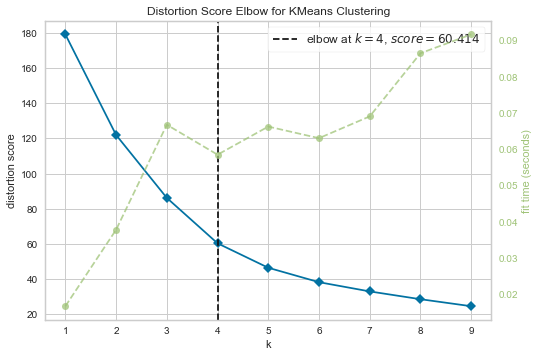

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
from yellowbrick.cluster import KElbowVisualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(scores)
visualizer.show()


In [54]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)

kmeans.fit(scores)
y_pred = kmeans.predict(scores)
df_user['group'] = y_pred
df_user.head()

,uid,quality,engagement,outcome,capacity,participation,score,rank,group
4957,678,99.13124,20.00000,39.917340,18.248190,30.540844,40.569964,1.0,2
2755,488,55.46828,16.60725,73.274514,49.247930,25.744932,40.277775,2.0,2
2937,679,50.88815,4.84922,50.643214,30.022298,36.244335,33.190548,3.0,2
2333,2985,76.43688,9.99678,0.000000,34.802788,38.052800,30.988984,4.0,2
5772,246,65.10512,18.86841,1.058412,41.456600,28.443961,29.376955,5.0,2


In [55]:
kmeans.inertia_

60.41391372563377

## Explore the group characteristics 

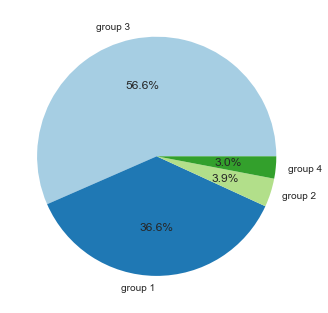

In [56]:
group = pd.DataFrame(df_user['group'].value_counts()).reset_index() 
group.columns = ['group', 'counts']
lb = ['group 3', 'group 1', 'group 2', 'group 4']
sns.set_palette('Paired')
plt.pie(group['counts'], labels = lb, autopct = '%1.1f%%' )
plt.show()

In [57]:
df_user.groupby('group').agg({'quality': 'mean', 'engagement':'mean', \
                           'outcome':'mean', 'capacity':'mean',\
                           'participation': 'mean',\
                           'score': 'mean'})

,quality,engagement,outcome,capacity,participation,score
group,,,,,,
0,0.001822,0.001029,0.049371,10.529724,0.343275,1.369146
1,0.021042,0.010332,0.059906,0.391700,0.769780,0.279592
2,34.814534,2.297871,2.250148,11.000638,3.990816,9.660637
3,3.019185,0.241580,2.013571,33.960204,2.763414,5.812855
